In [20]:
import numpy as np
from numpy.polynomial import polynomial as P
from matplotlib import pyplot as plt
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
from scipy import optimize
import pickle
from scipy import stats
from scipy.stats.mstats import theilslopes
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import os
from scipy import ndimage
from sklearn.linear_model import LinearRegression

In [314]:
#load data
experiment_run_name = "sxrx34917run88.h5"
my_file = experiment_run_name
my_hdf5_object = h5py.File(my_file,"r")


In [315]:
list(my_hdf5_object.keys())

['Acq01',
 'Acq02',
 'GMD',
 'GoldEye',
 'att_detector',
 'delay_stage_detector',
 'ebeam',
 'event_time',
 'evr',
 'fiducials',
 'gas_detector',
 'theta_polarizer_detector',
 'vitara_timing']

In [316]:
vitara_timing = np.array(my_hdf5_object["vitara_timing"])

In [317]:
vitara_timing

array([-0.0174, -0.0174, -0.0174, ..., -0.0174, -0.0174, -0.0174])

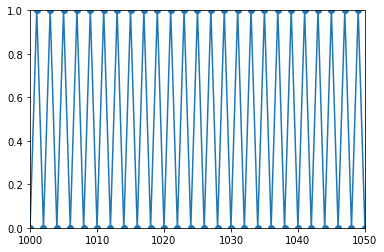

In [377]:
fiducials = np.array(my_hdf5_object["fiducials"])
mode = (fiducials%6)/3
plt.plot(mode,marker='o')
plt.ylim([0,1])
plt.xlim([1000,1050])
plt.show()

In [378]:
fiducials

array([42138, 42141, 42144, ..., 65304, 65307, 65310])

In [379]:
list(my_hdf5_object["evr"].keys()) #list of all event codes

['code_140', 'code_162', 'code_43', 'code_76', 'code_78', 'code_79', 'code_81']

In [380]:
np.array(my_hdf5_object["evr/code_76"]).shape

(7725,)

In [381]:
sum(np.array(my_hdf5_object["evr/code_76"])) #sum over all code_76 to see how many "0" are in there

6867

In [382]:
np.array(my_hdf5_object["evr/code_162"])

array([0, 0, 0, ..., 0, 0, 0])

In [383]:
my_images = np.array(my_hdf5_object['GoldEye/image'])

In [384]:
my_mask_1 = np.array(my_hdf5_object["evr/code_76"])==0 #use this to filter out the code_76 images = background
my_mask_2 = np.array(my_hdf5_object["evr/code_162"])==1 
#my_background_mask = my_mask_1 & my_mask_2 #use for run76
my_background_mask = my_mask_1
background_images = my_images[my_background_mask]

my_mask_3 = np.array(my_hdf5_object["evr/code_76"])==1 
my_mask_4 = np.array(my_hdf5_object["evr/code_162"])==0
my_mask_5 = mode==0;
my_non_background_mask = my_mask_3 & my_mask_4
my_filtered_images = my_images[my_non_background_mask] #all non-background images
my_filtered_images.shape

(6867, 100, 100)

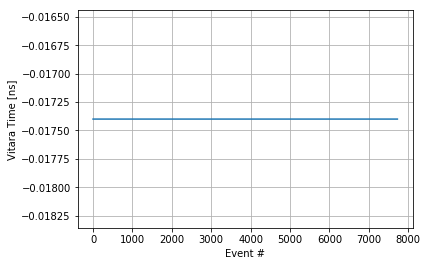

In [385]:
vitara_timing = np.array(my_hdf5_object["vitara_timing"])
plt.plot(vitara_timing)
plt.grid(b=None, which='major', axis='both')
plt.xlabel('Event #')
plt.ylabel('Vitara Time [ns]')
plt.show()

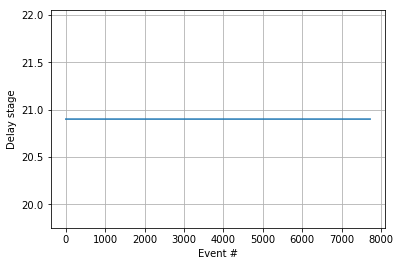

In [386]:
delay_stage = np.array(my_hdf5_object["delay_stage_detector"])
plt.plot(delay_stage)
plt.grid(b=None, which='major', axis='both')
plt.xlabel('Event #')
plt.ylabel('Delay stage')
plt.show()

In [387]:
background_images.shape

(858, 100, 100)

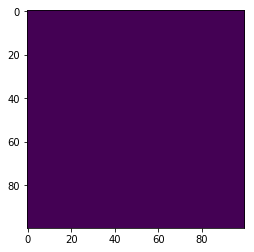

In [388]:
#avg_background = np.mean(background_images,axis=0) #average over all background images
avg_background = np.zeros((100,100))  #make background image with zeros
plt.imshow(avg_background)
plt.show()

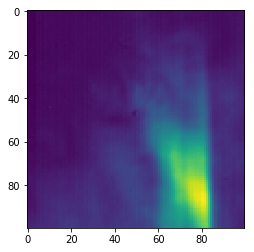

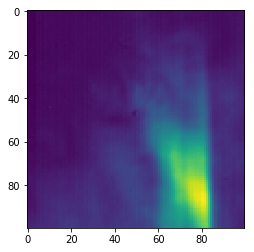

In [389]:
image_number = 1000
plt.imshow((my_filtered_images)[image_number]) #image before background subtraction
plt.show()
plt.imshow((my_filtered_images-avg_background)[image_number]) #image after background subtraction
plt.show()


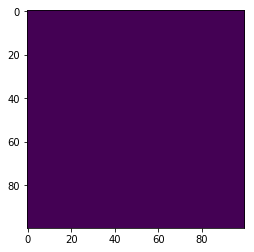

(100, 100)

In [390]:
#ref = np.loadtxt('ref.txt')
ref = np.ones((100,100))  #make background image with zeros

#ref = np.mean((my_filtered_images-avg_background)[10000:12000],axis=0)  #reference image when time was moved far away
plt.imshow(ref) #reference image when fully pumped and time was far away
plt.show()

ref.shape

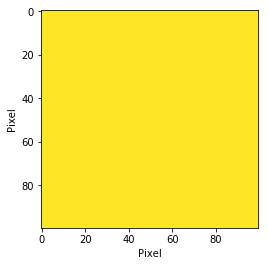

In [391]:
test = (my_filtered_images-avg_background)[1000]/(ref+10)
np.std(test)
plt.imshow(test)
plt.clim(0,1)
plt.xlabel('Pixel')
plt.ylabel('Pixel')
#plt.colorbar()
plt.show()

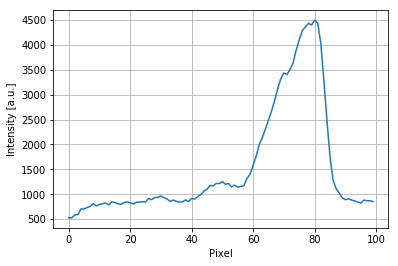

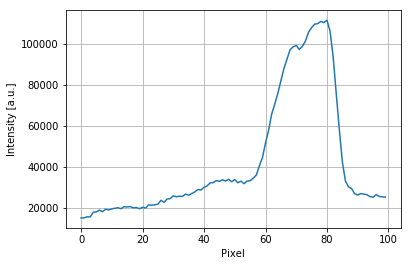

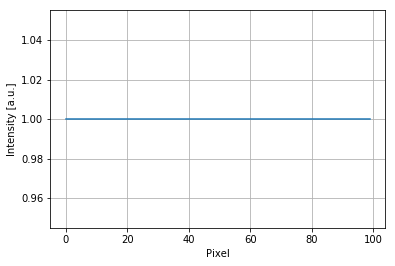

In [392]:
plt.plot((my_filtered_images-avg_background)[image_number,85,:])  #line profile of single pixel row
plt.grid(b=None, which='major', axis='both')
plt.xlabel('Pixel')
plt.ylabel('Intensity [a.u.]')
plt.show()

plt.plot(np.sum((my_filtered_images-avg_background)[image_number,60:90,:],axis=0))  #line profile of pixel row range
plt.grid(b=None, which='major', axis='both')
plt.xlabel('Pixel')
plt.ylabel('Intensity [a.u.]')
plt.show()

plt.plot(ref[80,:])  #line profile of ref image at single pixel row
plt.grid(b=None, which='major', axis='both')
plt.xlabel('Pixel')
plt.ylabel('Intensity [a.u.]')
plt.show()

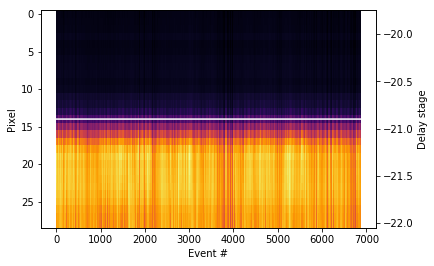

In [393]:
#proj = (((my_filtered_images-avg_background)/(ref+10))[:,65,:]) #single pixel row
proj = (np.sum(((my_filtered_images-avg_background)/(ref+10))[:,60:90,:],axis=1))  #sum over multiple pixel rows

plt.imshow(proj[:,:70:-1].transpose(),aspect='auto',cmap='inferno')
#plt.clim(0,10)
plt.xlabel('Event #')
plt.ylabel('Pixel')

#plt.show()
plt.twinx()
plt.plot((-1)*(delay_stage)[my_non_background_mask],color='white')
#plt.ylim(0.017,0.01945)
plt.ylabel('Delay stage')
plt.show()


In [394]:
(vitara_timing)[my_non_background_mask][1000]

-0.01739999999972497

In [453]:
window_size = 3
proj.shape
pixels_t0 = np.argmin(np.diff(proj,axis=1),axis=1)
#$pixels_t0 = np.argmax(ndimage.filters.convolve1d(np.ones(6),np.diff(proj,axis=1),axis=1),axis=1)

recalculated_atm = []
recalculated_atm_cov = []
background_subtracted = 0+proj[:,65:]
def peakFunction(x,a,x0,offset):
    return a*(x-x0)**2+offset
for i in np.arange(len(background_subtracted)):
    filtered_signal = savgol_filter(background_subtracted[i],5,2,1)      #calculates the rolling slope over 25 points
    win_c = np.argmin(filtered_signal)
    initial_guess = [1,win_c,filtered_signal[win_c]]
    try:
        #fitting peak with a parabola
        popt,pcov = curve_fit(peakFunction,np.arange(win_c-window_size,win_c+window_size),filtered_signal[win_c-window_size:win_c+window_size], p0=initial_guess)
        #popt,pcov = curve_fit(peakFunction,np.arange(win_c-window_size,win_c+window_size+1),np.diff(background_subtracted[i])[win_c-window_size:win_c+window_size+1], p0=initial_guess)
        
        
        recalculated_atm.append(popt[1])
        recalculated_atm_cov.append(pcov[1,1])
    except (RuntimeError,ValueError):
        recalculated_atm.append(-999.0)
        recalculated_atm_cov.append(-999.0)

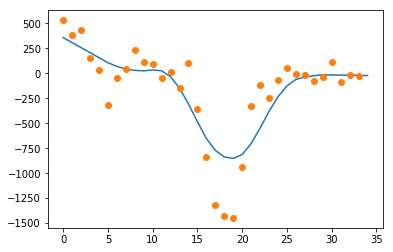

In [454]:
plt.plot(savgol_filter(background_subtracted[i],11,2,1))
plt.plot(np.diff(background_subtracted[i]),"o")

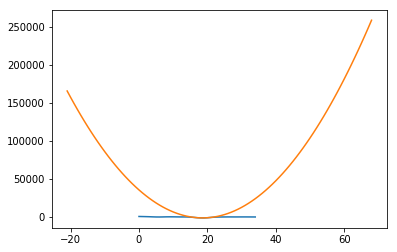

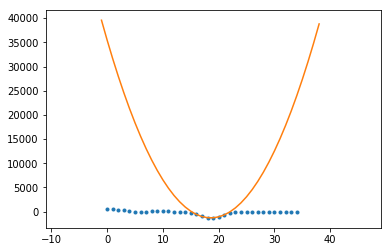

In [455]:
#the filtered_signal is rolling slope over 25 points. instead of convolving with a step function
plt.plot(filtered_signal)
plt.plot(np.arange(win_c-40,win_c+50),peakFunction(np.arange(win_c-40,win_c+50),*popt))
#plt.ylim(-100,200)
plt.show()
#zooming in
plt.plot(filtered_signal,'.')
window_size = 20
plt.plot(np.arange(win_c-window_size,win_c+window_size),peakFunction(np.arange(win_c-window_size,win_c+window_size),*popt))
plt.xlim(win_c-30,win_c+30)
plt.show()


In [456]:
fit_mask = np.ones(len(recalculated_atm))
fit_mask *= ((np.array(recalculated_atm))>0)
fit_mask *= (vitara_timing[my_non_background_mask]<-0.01835)  #fit upper limit
fit_mask *= (vitara_timing[my_non_background_mask]>-0.0186)  #fit lower limit
fit_mask = fit_mask.astype(bool)

def linearFunction(x,slope,offset):
    return slope*x+offset
popt,pcov = curve_fit(linearFunction, vitara_timing[my_non_background_mask][fit_mask], np.array(recalculated_atm)[fit_mask])

x_temp = np.arange(-0.0176,-0.0186,-0.0001) 
plt.plot(vitara_timing[my_non_background_mask],recalculated_atm,marker = ".",linewidth=0,alpha=0.2)
plt.plot(vitara_timing[my_non_background_mask][fit_mask],np.array(recalculated_atm)[fit_mask],marker = ".",linewidth=0,alpha=0.2)
plt.plot(x_temp,linearFunction(x_temp,*popt))
#plt.xlim(-0.0176,-0.0186)
plt.ylim(0,40)
plt.xlabel('Vitara Time [ns]')
plt.ylabel('Pixel')
plt.grid(b=None, which='major', axis='both')
plt.show()

TypeError: Improper input: N=2 must not exceed M=0

In [457]:
#calib = np.array([popt[0]/1000, (1/popt[0])*1e6])
calib #pixels/ps | fs/pixel

calib = ([-31.3121489 , -31.93648584])

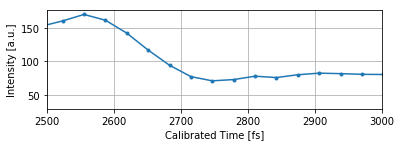

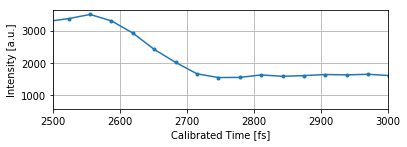

In [458]:
time_axis = np.arange(0,(-100*calib[1]),(-1*calib[1]))  #make time axis with pixel-to-fs calibration factor
image_number = 1000

plt.subplot(2,1,1)
plt.plot(time_axis,((my_filtered_images-avg_background)/(ref+10))[image_number,50,:],linestyle='-', marker='.')
plt.xlim(2500,3000)
#plt.ylim(-0.5,6)
plt.xlabel('Calibrated Time [fs]')
plt.ylabel('Intensity [a.u.]')
plt.grid(b=None, which='major', axis='both')
plt.show()

plt.subplot(2,1,2)
plt.plot(time_axis,np.sum(((my_filtered_images-avg_background)/(ref+10))[image_number,40:60,:],axis=0),linestyle='-', marker='.')
plt.xlim(2500,3000)
#plt.ylim(-10,100)
plt.xlabel('Calibrated Time [fs]')
plt.ylabel('Intensity [a.u.]')
plt.grid(b=None, which='major', axis='both')
plt.show()

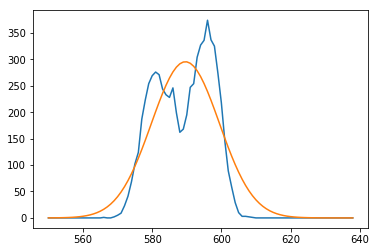

In [469]:
def gaussian(x, mu, ampl, sig):
    return ampl*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

initial_guess = [590,300,20]
counts,bins = np.histogram(edge_pos[0:10000],bins=np.arange(550,640,1))
popt,pcov = curve_fit(gaussian,bins[:-1],counts, p0=initial_guess)

plt.plot(bins[:-1],counts)
plt.plot(bins[:-1],gaussian(bins[:-1],*popt))

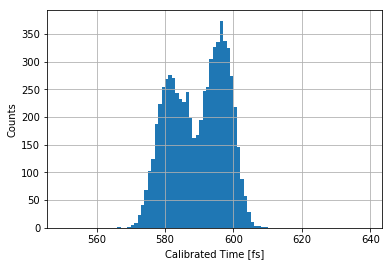

In [459]:
edge_pos = np.array(recalculated_atm)*(-1*calib[1])
plt.hist(edge_pos[0:10000],bins=np.arange(550,640,1))
plt.xlabel('Calibrated Time [fs]')
plt.ylabel('Counts')
plt.grid(b=None, which='major', axis='both')
plt.show()

In [376]:
edge_pos.shape

(644,)

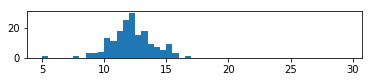

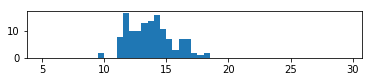

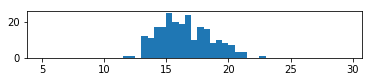

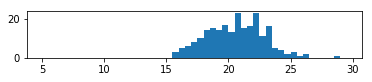

In [704]:
hist_mask = np.array(recalculated_atm)[(vitara_timing[my_non_background_mask]<-0.0166) & (vitara_timing[my_non_background_mask]>-0.01675)]
plt.subplot(4, 1, 1)
plt.hist(hist_mask, bins=np.arange(5,30,.5))
plt.show()

hist_mask = np.array(recalculated_atm)[(vitara_timing[my_non_background_mask]<-0.01675) & (vitara_timing[my_non_background_mask]>-0.01685)]
plt.subplot(4, 1, 2)
plt.hist(hist_mask, bins=np.arange(5,30,.5))
plt.show()

hist_mask = np.array(recalculated_atm)[(vitara_timing[my_non_background_mask]<-0.01685) & (vitara_timing[my_non_background_mask]>-0.01695)]
plt.subplot(4, 1, 3)
plt.hist(hist_mask, bins=np.arange(5,30,.5))
plt.show()

hist_mask = np.array(recalculated_atm)[(vitara_timing[my_non_background_mask]<-0.01695) & (vitara_timing[my_non_background_mask]>-0.01705)]
plt.subplot(4, 1, 4)
plt.hist(hist_mask, bins=np.arange(5,30,.5))
plt.show()


In [152]:
def my_function(x):
    return x+1

In [4]:
my_hdf5_object.close()

In [53]:
my_images.shape

(6164, 100, 100)

In [61]:
my_filtered_images.shape

(685, 100, 100)